In [4]:
class Brick( object ):
    import sympy
    wall_width = 100
    layers = {} # key: row; value: list of brick objects
    num_layers = None
    count = 0
    all_bricks = []
    bottom_layer = None
    vine_colors = None

    def __init__( self, layer, index, leftx, rightx ):
        self.layer = layer
        self.index = index
        self.leftx = leftx
        self.rightx = rightx
        self.width = rightx - leftx
        self.label = self.__class__.count
        self.vine = None
        self.__class__.count += 1
        if layer not in self.layers:
            self.layers[layer] = []
        self.layers[layer].append( self )
        self.all_bricks.append( self )

    @classmethod
    def ValidPathFromEdges( cls, leftx_0, rightx_0, layer_index=None):

        if layer_index == None:
            layer_index = len( cls.layers )
        if layer_index < 1:
            return []
        
        this_layer = cls.layers[ layer_index ]
        
        # Should be only 1
        b_above = [ b.label for b in this_layer if b.leftx <= leftx_0 and b.rightx >= rightx_0 ]
        assert len( b_above ) <= 1

        #if b_above:
        #    print "layer {} brick {}".format( layer_index, b_above[0] )
        #else:
        #    print "layer {} nada".format( layer_index )
            
        retval = cls.ValidPathFromEdges( leftx_0, rightx_0, layer_index -1 )
        #print "retval={}".format( retval )
        #print "b_above={}".format( b_above )
        return b_above + retval


    def __str__( self ):
        return "<B-{}: L-{}-{} x1={} x2={}>".format( self.label, self.layer, self.index, self.leftx, self.rightx )
    def __repr__( self ):
        return str( self )
    
    @classmethod
    def KnockDown( cls ):
        cls.layers = {}
        cls.count = 0
        cls.all_bricks = []
        
    @classmethod
    def Reset( cls ):
        for b in cls.all_bricks:
            b.vine=None
        for b in cls.bottom_layer:
            b.vine = b.index

    @classmethod
    def AllPathEdges( cls ):
        lefts = sorted( set( [ b.leftx for b in cls.all_bricks ] ) )
        lefts.append( cls.sympy.Rational( cls.wall_width ) )
        return lefts
    
    @classmethod
    def LaneEdgesForEachBrick( cls ):
        lanes = {}
        all_path_edges = cls.AllPathEdges()
        for b in cls.bottom_layer:
            l = b.leftx
            r = b.rightx
            index = b.index
            brick_lane_list = []
            for i in xrange( len( all_path_edges ) - 1 ):
                lp = all_path_edges[i]
                rp = all_path_edges[i+1]
                if lp >= l and rp <= r:
                    brick_lane_list.append( ( lp,rp ))
            lanes[ index ] = brick_lane_list
        return lanes
    
    @classmethod
    def AllPaths( cls ):
        paths = {}
        lanes = cls.LaneEdgesForEachBrick()
        for bottom_brick_index, edge_pair_list in lanes.iteritems():
            path_list = []
            for left, right in edge_pair_list:
                #print "l: {}, r: {}".format( left, right)
                path_list.append( cls.ValidPathFromEdges( left, right ) )
            paths[ bottom_brick_index ] = path_list
        return paths
    
    @classmethod
    def BottomLayerEdges( cls ):
        lefts = sorted( set( [ b.leftx for b in cls.bottom_layer ] ) )
        lefts.append( cls.sympy.Rational( cls.wall_width ) )
        return lefts

    @classmethod
    def layrow( cls, n_bricks_in_layer ):
        """Return the layer you just made"""
        if n_bricks_in_layer == 0:
            return None
        brick_width = cls.sympy.Rational( cls.wall_width, n_bricks_in_layer )
        for i in xrange( n_bricks_in_layer ):
            leftx = i * brick_width
            rightx = (i + 1) * brick_width
            cls( n_bricks_in_layer, i, leftx, rightx)
        return cls.layers[ n_bricks_in_layer ]

    @classmethod
    def BuildWall( cls, n_layers ):
        cls.KnockDown()
        last_layer = None
        cls.num_layers = n_layers
        for i in xrange( 1, n_layers + 1):
            last_layer = cls.layrow( i )
        cls.bottom_layer = last_layer
        import matplotlib.pyplot as plt
        from numpy.random import rand
        cls.vine_colors = rand(len(last_layer)+1 , 3)
        for b in last_layer:
            b.vine = b.index
        
    @classmethod
    def DrawWall( cls ):
        import matplotlib.pyplot as plt
        from matplotlib.path import Path
        import matplotlib.patches as patches
        
        fig = plt.figure( figsize=(15,8) )
        ax = fig.add_subplot(111)
        
        codes = [
            Path.MOVETO,
            Path.LINETO,
            Path.LINETO,
            Path.LINETO,
            Path.CLOSEPOLY,
        ]
        
        bottom_layer_index = max( cls.layers.keys() )
        for b in cls.all_bricks:
            #print b
            verts = [
                ( float( b.leftx ), -1 * b.layer), # left, top
                ( float( b.rightx ), -1 * b.layer), # right, top
                ( float( b.rightx ), -1 * (b.layer + 1) ), # right, bottom
                ( float( b.leftx ), -1 * (b.layer + 1) ), # left, bottom
                ( float( b.leftx ), -1 * b.layer), # left, top, # ignored
            ]
            path = Path(verts, codes)
            if b.vine is not None:
                color = cls.vine_colors[b.vine]
                patch = patches.PathPatch(path, label=b.label, linestyle='solid', ec='black', fill=True, color=color)
            else:
                patch = patches.PathPatch(path, label=b.label, linestyle='solid', ec='black', fill=False)
            ax.add_patch(patch)

        ax.set_xlim(0, 100)
        ax.set_ylim(-1 * (1 + bottom_layer_index ), -1)

        plt.show()
        
    @classmethod
    def SolveMonteCarlo( cls, seed=None ):
        """Find a solution to the vine problem with the currently constructed wall."""

        # Clear out previous vines
        cls.Reset()
        total_num_bricks = len( cls.all_bricks )
        num_used_bricks = 0
        proposed_vines = None
        
        all_possible_paths = cls.AllPaths()
        from numpy.random import RandomState
        r = RandomState(seed)
        import numpy as np
        order = np.arange( 1, cls.num_layers + 1 )

        # Stop iterating when you find a solution that uses all the bricks
        while num_used_bricks != total_num_bricks:
            selected_paths = []
            for initial_brick in all_possible_paths:
                # First randomly pick a single path for each vine
                vine_paths = all_possible_paths[ initial_brick ]
                selected_paths.append( vine_paths[ r.randint( len( vine_paths ) ) ] )
            proposed_vines = []
            r.shuffle( order )
            for path, height in zip( selected_paths, order ):
                proposed_vines.append( path[:height] )
            num_used_bricks = len( set( [ b for vine in proposed_vines for b in vine ]) )
            
        # Now that we have a solution, set the colors and draw the wall
        for i, vine_list in enumerate( proposed_vines ):
            for b_label in vine_list:
                cls.all_bricks[ b_label ].vine = i
        
        cls.DrawWall()

In [2]:
%matplotlib inline

In [254]:
Brick.BuildWall(10)

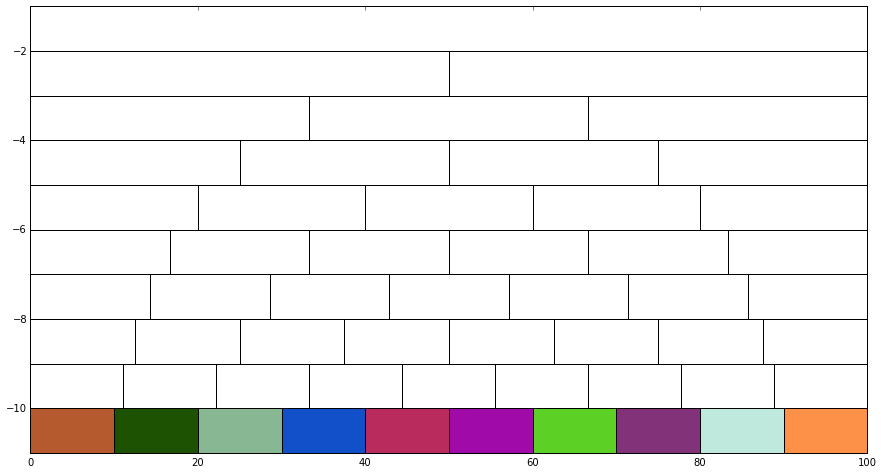

In [255]:
Brick.DrawWall()

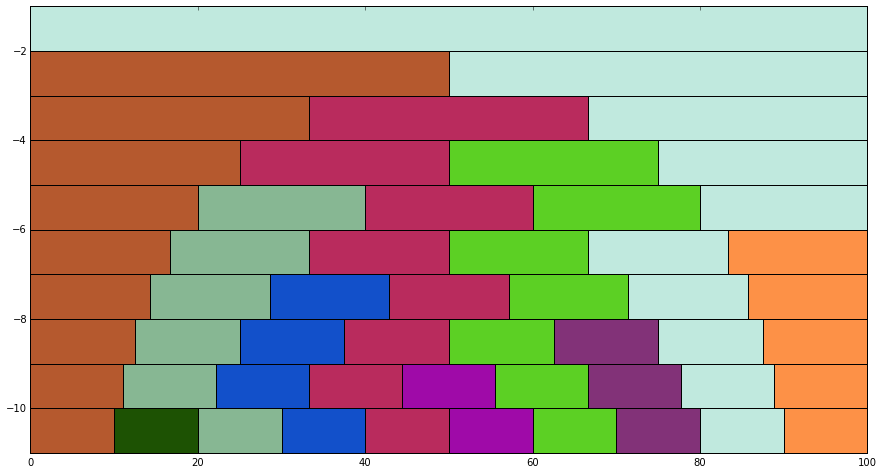

In [256]:
Brick.SolveMonteCarlo()

In [5]:
Brick.BuildWall(13)

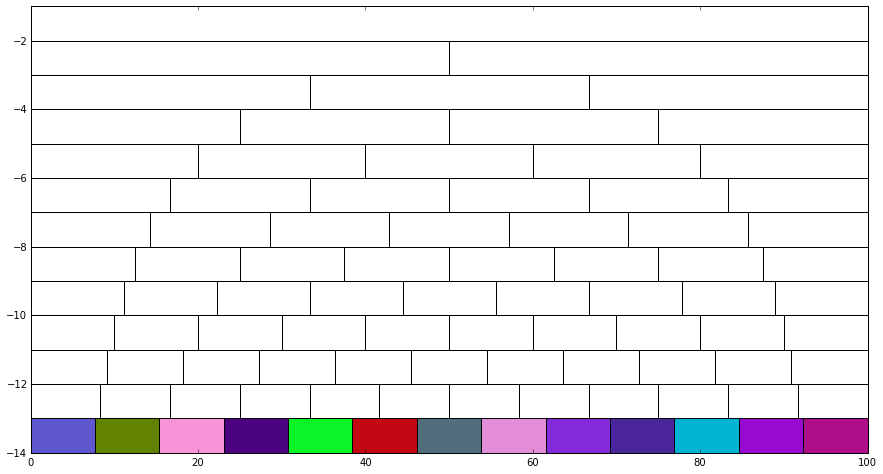

In [6]:
Brick.DrawWall()

In [7]:
import time

In [8]:
t1 = time.time()
Brick.SolveMonteCarlo()
t2 = time.time()

KeyboardInterrupt: 